# Sparkify - Customer chunk predicition

In this project, I'm going to build an end to end data pipeline starting with data streaming from Sparkify backend to Kafka cluster. There will be a dedicated Spark streaming application to consumer the stream message and ingest to Hadoop, stored as parquet format, and retrieved with HiveQL on HUE, or Spark SQL via Jupyter. There is another Spark Batch job to run the model after the experiment on Jyputer. The experiment in this Jupyter Notebook focuses on building model for the analysis and prediction the churn rate metric.

The full data pipeline looks as below:

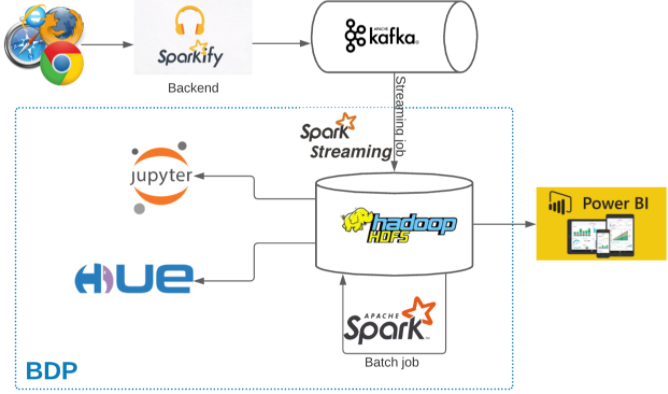

In [1]:
# import libraries
from pyspark.sql import SparkSession, Window

from pyspark.sql.types import *
import pyspark.sql.functions as psf


from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, OneHotEncoderEstimator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import IntegerType, ArrayType, FloatType, DoubleType, Row, DateType
from pyspark.ml.linalg import DenseVector, SparseVector
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator,BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from time import time
import re
import numpy as np
import scipy
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import random
from itertools import chain
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## 1. Load and Clean Dataset

### 1.1. Load data

Load data from Hive data base which is ingested from Kafka. Since I do the analysis on the big data cluster with mutiple node, then there is no issue with playing the `medium` sparkify dataset (including 543705 rows).

In [2]:
# Load from local source as a prototype
target_table = "bdp_ap_it.sparkify_event"
spark.sql(f"refresh table {target_table}")
df = spark.sql(f"select * from {target_table}")
df.limit(3).toPandas()

,ts,userid,sessionid,page,iteminsession,auth,method,status,level,location,useragent,lastname,firstname,registration,gender,artist,song,length,part_date
0,1541701748000,143,3219,NextSong,98,Logged In,PUT,200,paid,"Virginia Beach-Norfolk-Newport News, VA-NC","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Harrison,Molly,1534255113000,F,Dominique A,Le Courage Des Oiseaux,153.20771,20181109
1,1541701748000,92,3340,NextSong,286,Logged In,PUT,200,paid,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (iPad; CPU OS 7_1_2 like Mac OS X...",Taylor,Riley,1536403972000,F,Crystal Castles,Reckless,208.40444,20181109
2,1541701753000,230,3261,NextSong,477,Logged In,PUT,200,paid,"Albemarle, NC","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Lucero,Quinn,1527341164000,M,OneRepublic,Secrets,224.67873,20181109


In [8]:
# Check the schema
df.printSchema()

root
 |-- ts: long (nullable = true)
 |-- userid: string (nullable = true)
 |-- sessionid: integer (nullable = true)
 |-- page: string (nullable = true)
 |-- iteminsession: integer (nullable = true)
 |-- auth: string (nullable = true)
 |-- method: string (nullable = true)
 |-- status: string (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- useragent: string (nullable = true)
 |-- lastname: string (nullable = true)
 |-- firstname: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- song: string (nullable = true)
 |-- length: double (nullable = true)



### 1.2. Check for missing values

Check row count and data missing

In [4]:
# Check how many rows in the input raw data
df.count()

543705

In [9]:
# Check the null values per columns
df_agg = df.agg(*[psf.count(psf.when(psf.isnull(c) | ("" == psf.col(c)), c)).alias(c) for c in df.columns])
df_agg.toPandas().transpose()

,0
ts,0
userid,15700
sessionid,0
page,0
iteminsession,0
auth,0
method,0
status,0
level,0
location,15700


As seen in above result, there are null/empty values on `userid` which is expexted not nullable. Reload data by filtering the null and empty data for both 2 key columns `userid` and `sessionid` to prevent additional issue with bigger dataset.

In [40]:
df = spark.sql(f"select * from {target_table} where userid is not null and sessionid is not null and userid <>''")

# Drop technical column partdate which is not useful for now
df = df.drop("part_date")
df.limit(2).toPandas()

,ts,userid,sessionid,page,iteminsession,auth,method,status,level,location,useragent,lastname,firstname,registration,gender,artist,song,length
0,1541701748000,143,3219,NextSong,98,Logged In,PUT,200,paid,"Virginia Beach-Norfolk-Newport News, VA-NC","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Harrison,Molly,1534255113000,F,Dominique A,Le Courage Des Oiseaux,153.20771
1,1541701748000,92,3340,NextSong,286,Logged In,PUT,200,paid,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (iPad; CPU OS 7_1_2 like Mac OS X...",Taylor,Riley,1536403972000,F,Crystal Castles,Reckless,208.40444


## 2. Exploratory Data Analysis (EDA)

Perform EDA using a small subset of the full dataset.

### 2.1. Overview of numerical columns

A quick look at descriptive statistics for numerical columns

In [6]:
num_vars = ['ts', 'itemInSession', 'registration', 'length']
df.select(num_vars).describe().show(truncate=False)

+-------+---------------------+------------------+---------------------+------------------+
|summary|ts                   |itemInSession     |registration         |length            |
+-------+---------------------+------------------+---------------------+------------------+
|count  |543705               |543705            |528005               |432877            |
|mean   |1.5409645412098237E12|107.30629109535502|1.5355234148639204E12|248.66459278007366|
|stddev |1.4820571449110553E9 |116.72350849188159|3.0787254929959145E9 |98.4126695505202  |
|min    |1538352011000        |0                 |1509854193000        |0.78322           |
|max    |1543622466000        |1005              |1543073874000        |3024.66567        |
+-------+---------------------+------------------+---------------------+------------------+



### 2.2. Overview of categorical columns

A quick look at the possible categories.

In [19]:
cat_vars = ['page', 'auth', 'method', 'status', 'level', 'location', 'useragent', 
            'lastname', 'firstname', 'gender', 'artist', 'song']
for col in cat_vars:
    print(f"\n+ {col}:")
    df.select(col).distinct().show(truncate=False)


+ page:
+-------------------------+
|page                     |
+-------------------------+
|Cancel                   |
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|Cancellation Confirmation|
|About                    |
|Settings                 |
|Add to Playlist          |
|Add Friend               |
|NextSong                 |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
|Error                    |
|Submit Upgrade           |
+-------------------------+


+ auth:
+---------+
|auth     |
+---------+
|Cancelled|
|Logged In|
+---------+


+ method:
+------+
|method|
+------+
|PUT   |
|GET   |
+------+


+ status:
+------+
|status|
+------+
|307   |
|200   |
|404   |
+------+


+ level:
+-----+
|level|
+-----+
|free |
|paid |
+-----+


+ location:
+--------------------------------------+
|location 

Based on what data we have, I plan to use number of variables which are most relevant impacting the the **churn rate**. 
* Numerical variables:
    * Existing vars:
        * **length**: the duration of the song user listening to
        * **iteminsession**: number of interactions per session of using our music service
    * Derived vars from *ts* & *registration*:
        * month & date of logged event derived from `ts` for further grouping and analysis
        * registered_days derived from `registration` to measure how long of using the service per using
* Categorical variables:
    * Existing vars: `gender`, `location`, `level`, `useragent`
    * Derived vars from **page** columns with number of relevant interaction types like: ThumpsDown, ThumpsUp, Downgrade, etc.

### 2.3. Define churn 
We label churn users as `1` with the event of `Cancellation Confirmation` on column `page` which happen for both paid and free users.

In [ ]:
df = spark.sql(f"select * from {target_table} where userid is not null and sessionid is not null and userid <>''")
df = df.drop("part_date")

In [49]:
# Define churn user as with page action on `Cancellation Confirmation` flag (1: churned, 0: not churned)
flag_churn = psf.udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("churned", flag_churn("page"))

# Check the data
df.where("page = 'Cancellation Confirmation'").limit(5).toPandas()

Because each user can log many events, then it required further step to perform the window partition to flag that user as churn user from history until the event happened.

In [57]:
# Perform window partition by userid and order by timestamp columns
windowval = Window.partitionBy("userid").orderBy(psf.asc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df = df.withColumn("churn_user", psf.max('churned').over(Window.partitionBy("userid")))

# Check the data
df.where("userid = '208'").limit(10).toPandas()

,ts,userid,sessionid,page,iteminsession,auth,method,status,level,location,...,length,churned,event_ts,date,device,last_event_userid,last_event,registered_days,last_level,churn_user
0,1538393903000,208,490,Home,1,Logged In,GET,200,free,IN,...,NaN,0,2018-10-01 11:38:23,2018-10-01,Windows,208,1538400616000,19,free,1
1,1538394381000,208,490,NextSong,2,Logged In,PUT,200,free,IN,...,268.51220,0,2018-10-01 11:46:21,2018-10-01,Windows,208,1538400616000,19,free,1
2,1538394383000,208,490,Help,3,Logged In,GET,200,free,IN,...,NaN,0,2018-10-01 11:46:23,2018-10-01,Windows,208,1538400616000,19,free,1
3,1538394409000,208,490,Home,4,Logged In,GET,200,free,IN,...,NaN,0,2018-10-01 11:46:49,2018-10-01,Windows,208,1538400616000,19,free,1
4,1538394649000,208,490,NextSong,5,Logged In,PUT,200,free,IN,...,224.13016,0,2018-10-01 11:50:49,2018-10-01,Windows,208,1538400616000,19,free,1
5,1538394873000,208,490,NextSong,6,Logged In,PUT,200,free,IN,...,275.30404,0,2018-10-01 11:54:33,2018-10-01,Windows,208,1538400616000,19,free,1
6,1538394874000,208,490,Thumbs Up,7,Logged In,PUT,307,free,IN,...,NaN,0,2018-10-01 11:54:34,2018-10-01,Windows,208,1538400616000,19,free,1
7,1538395148000,208,490,NextSong,8,Logged In,PUT,200,free,IN,...,247.01342,0,2018-10-01 11:59:08,2018-10-01,Windows,208,1538400616000,19,free,1
8,1538395204000,208,490,Home,9,Logged In,GET,200,free,IN,...,NaN,0,2018-10-01 12:00:04,2018-10-01,Windows,208,1538400616000,19,free,1
9,1538395395000,208,490,NextSong,10,Logged In,PUT,200,free,IN,...,293.22404,0,2018-10-01 12:03:15,2018-10-01,Windows,208,1538400616000,19,free,1


### 2.4. Explore data
Analyze the behavior for users who stayed vs users who churned.

In [50]:
# Derive the timestamp, date and location columns
df = (df
         .withColumn("event_ts", psf.from_unixtime(psf.col("ts")/1000).cast(TimestampType()))
         .withColumn("date", psf.from_unixtime(psf.col("ts")/1000).cast(DateType()))
         .withColumn("location", psf.split(psf.col("location"), ",").getItem(1))
        )
df.select("ts", "event_ts", "date", "location").limit(3).toPandas()

,ts,event_ts,date,location
0,1541701748000,2018-11-08 18:29:08,2018-11-08,VA-NC
1,1541701748000,2018-11-08 18:29:08,2018-11-08,MA-NH
2,1541701753000,2018-11-08 18:29:13,2018-11-08,NC


In [51]:
# Derive device using from useragent colum
get_device = psf.udf(lambda x: x.split("(")[1].replace(";", " ").split( )[0])
df = df.withColumn("device", get_device(psf.col("useragent")))
df.select("useragent", "device").limit(3).toPandas()

,useragent,device
0,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Macintosh
1,"""Mozilla/5.0 (iPad; CPU OS 7_1_2 like Mac OS X...",iPad
2,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Windows


In [52]:
# Calculate the registration days
last_event = (df
              .groupBy("userid").agg(psf.max("ts").alias("last_event"))
              ).withColumnRenamed("userid", "last_event_userid")
df = (df
      .join(last_event, df.userid == last_event.last_event_userid, how="left")
      .withColumn("registered_days", ((psf.col("last_event") - psf.col("registration"))/1000/86400).cast(IntegerType()))
     )

df.select("ts", "date", "registration", "registered_days").limit(3).toPandas()

,ts,date,registration,registered_days
0,1538991392000,2018-10-08,1538016340000,14
1,1538991618000,2018-10-08,1538016340000,14
2,1538991903000,2018-10-08,1538016340000,14


In [53]:
# Get latest level
last_level = df.orderBy("ts", ascending=False).groupBy("userid").agg(psf.first("level").alias("last_level")).withColumnRenamed("userid", "last_level_userid")
df = df.join(last_level, df.userid == last_level.last_level_userid, how="left").drop("last_level_userid")

In [55]:
# Check data based on new calculated columns
df.select("userid", "ts", "useragent", "location", "event_ts", "date", "location", "device", "registered_days", "last_level").limit(5).toPandas()

,userid,ts,useragent,location,event_ts,date,location,device,registered_days,last_level
0,100010,1539242427000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",CT,2018-10-11 07:20:27,2018-10-11,CT,iPhone,14,free
1,100010,1539242431000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",CT,2018-10-11 07:20:31,2018-10-11,CT,iPhone,14,free
2,100010,1539242448000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",CT,2018-10-11 07:20:48,2018-10-11,CT,iPhone,14,free
3,100010,1539242452000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",CT,2018-10-11 07:20:52,2018-10-11,CT,iPhone,14,free
4,100010,1539242894000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",CT,2018-10-11 07:28:14,2018-10-11,CT,iPhone,14,free


#### Churn user by level
Churn signal mostly seen at free level which is suitable in practice as they occupy more percentage in the distribution.

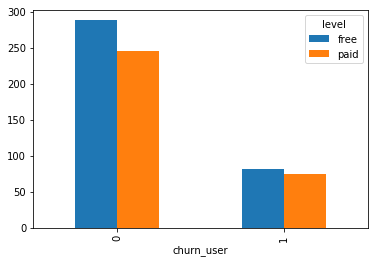

In [58]:
level_df = (df
           .select("userid", "level", "churn_user")
           .distinct()
           .groupBy("level", "churn_user")
           .agg(
               psf.count("userid").alias("count")
           )).toPandas()
level_df.pivot(index="churn_user", columns="level", values="count").plot(kind="bar");

#### Level usage by gender
Interesting finding that more males using the service as well as in both free and paid service.

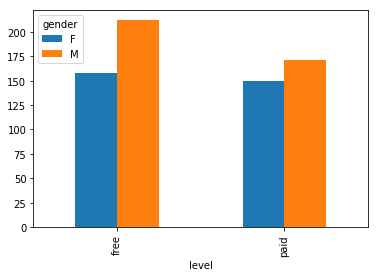

In [62]:
gender_df = (df
             .select("userid", "gender", "level")
             .distinct()
             .groupBy("gender", "level")
             .agg(psf.count("userid").alias("count"))
            ).toPandas()
gender_df.pivot(index="level", columns="gender", values="count").plot(kind="bar");

#### Level vs device
The log event collected from web browser which is easier to access from desktop device (Mac/Windows) instead of handheld devices. Because of the dominant, I will exclude this feature from model training. 

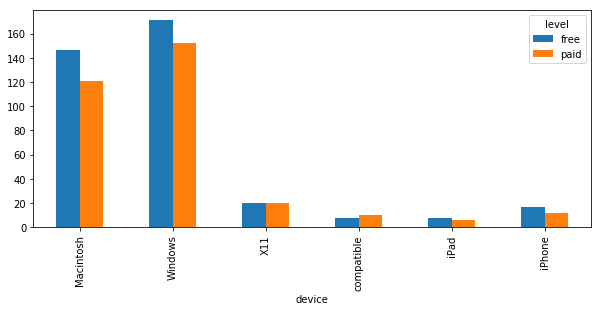

In [60]:
device_df = (df
             .select("userid", "device", "level")
             .distinct()
             .groupBy("device", "level")
             .agg(psf.count("userid").alias("count"))
            ).toPandas()
device_df.pivot(index="device", columns="level", values="count").plot(kind="bar", figsize=(10, 4));

#### Churn vs registered days
As seen from below historgram, we found more churned users at shorter registered days.

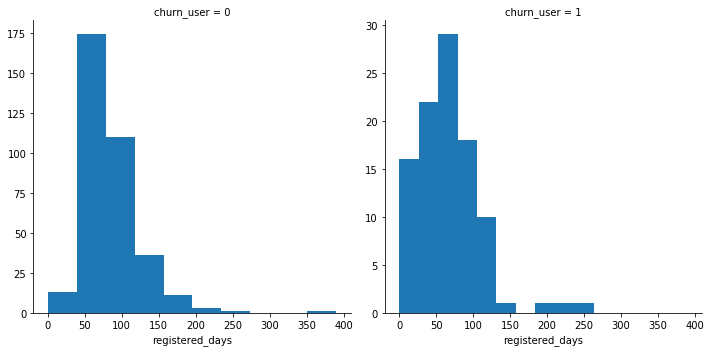

In [66]:
register_df = (df
               .select("userid", "churn_user", "registered_days")
               .groupBy("userid", "churn_user")
               .agg(psf.avg("registered_days").alias("registered_days"))
              ).toPandas()
g = sns.FacetGrid(register_df, col="churn_user", sharey=False, height=5, aspect=1)
g.map(plt.hist, "registered_days");

#### Churn vs. Session count
Not much info can derive from the two chart, they both prensent similar distribution

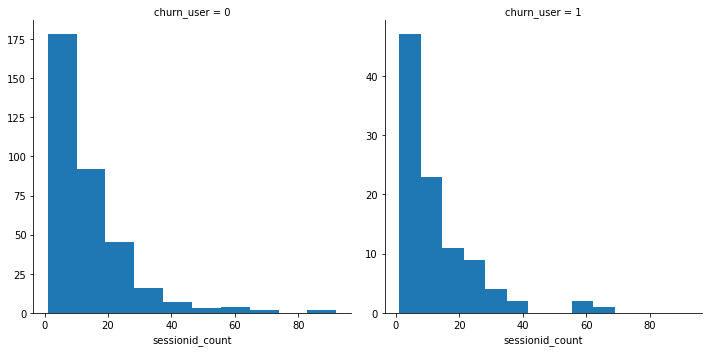

In [68]:
session_df = (df
              .select("userid", "churn_user", "sessionid")
              .distinct()
              .groupBy(["userid", "churn_user"])
              .agg(
                  psf.count("sessionid").alias("sessionid_count")
              )).toPandas()
g = sns.FacetGrid(session_df, col="churn_user", sharey=False, height=5, aspect=1)
g.map(plt.hist, "sessionid_count");

#### Churn vs. average item in session
Churn user tends to have less average item in each session.

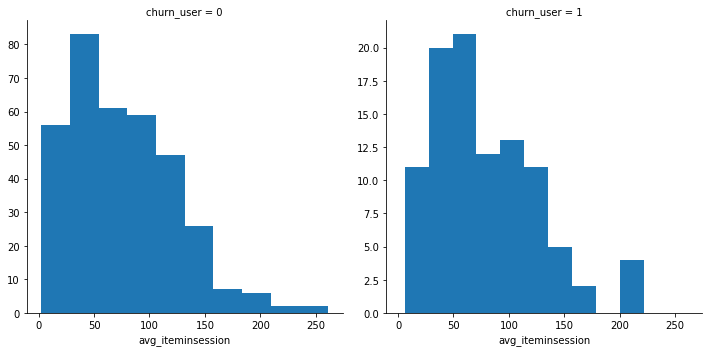

In [70]:
item_df = (df
           .select("userid", "churn_user", "iteminsession")
           .groupBy(["userid", "churn_user"])
           .agg(
               psf.avg("iteminsession").alias("avg_iteminsession")
           )).toPandas()

g = sns.FacetGrid(item_df, col="churn_user", sharey=False, height=5, aspect=1)
g.map(plt.hist, "avg_iteminsession");

#### Churn vs location
We observed the high usage of users comming from CA, NY-NJ-PA and TX. Because of so many locations, it is better to group into serveral regions/areas. In this experiment, I will exclude locations from the feature calculation.

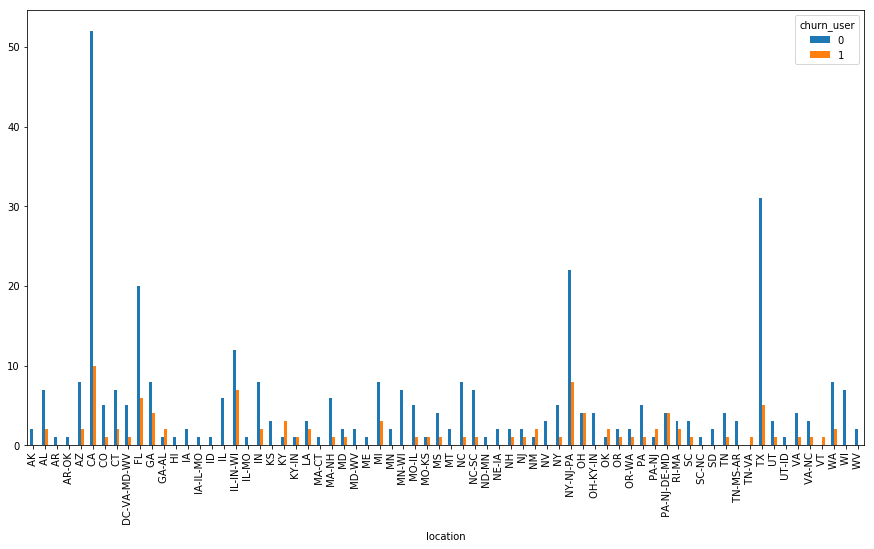

In [71]:
location_df = (df
               .select("userid", "location", "churn_user")
               .distinct()
               .groupBy("location", "churn_user")
               .agg(psf.count("userid").alias("count"))
            ).toPandas()
location_df.pivot(index="location", columns="churn_user", values="count").plot(kind="bar", figsize=(15,8));

#### Churn vs page event
This data required the pivot opration to transpose the event to column. The box-plot chart shows the comparision the usage range of both churned and non-churned users. 

In [72]:
page_df = (df
           .groupBy("userid")
           .pivot("page")
           .count()
           .fillna(0)
          ).withColumnRenamed("Cancellation Confirmation", "Churn").toPandas()
page_df.head()

,userid,About,Add Friend,Add to Playlist,Cancel,Churn,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,100010,0,3,1,1,1,0,0,0,3,1,96,22,0,0,0,0,3,4,2
1,200002,1,2,6,1,1,3,0,1,23,11,310,11,0,2,0,1,5,15,2
2,296,0,2,3,1,1,1,0,2,7,3,112,9,0,1,0,1,0,8,1
3,125,0,3,2,0,0,0,0,2,2,0,62,6,0,3,0,0,1,3,0
4,124,3,26,45,1,1,21,0,10,70,17,1826,1,3,15,0,0,15,102,0


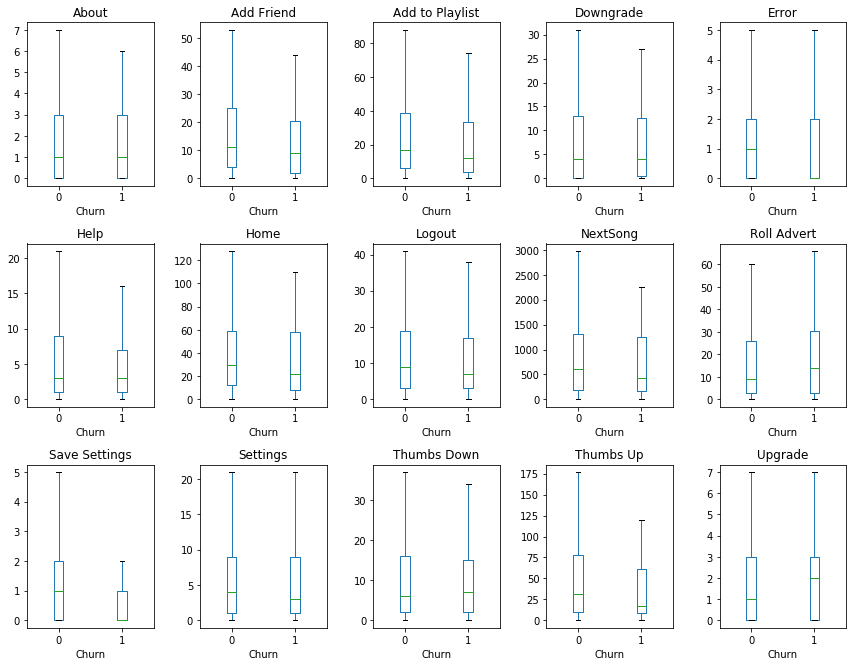

In [73]:
fig = plt.figure(figsize=(12,12))
check_cols = ['About', 'Add Friend', 'Add to Playlist', 'Downgrade', 'Error', 'Help', 'Home', 
                 'Logout', 'NextSong', 'Roll Advert', 'Save Settings', 'Settings', 'Thumbs Down', 
                 'Thumbs Up', 'Upgrade']

for i, col in enumerate(check_cols):
    ax = fig.add_subplot(4, 5, i+1)
    page_df.boxplot(col, ax=ax, grid=False,  by='Churn', showfliers=False);

fig.suptitle('')
plt.tight_layout()

Churn users seems having less interation in general picture. There are 2 interesting findings: churn users have less `Thumbs up`, more `Thumps down` and `Roll Advert`. Next steps is to feed these features into machine learning algorithm to identify which contributes most to the churning rate.

## 3. Feature Engineering

In this section, we will organize all draft code running above by packaging into function. 

In [8]:
def load_and_clean(target_table):
    """
    Extract data raw data and perform cleaning null and empty values on userid and sessionid column
    Agrs:
        target_table: input table name from Hive database
    Returns:
        df: return dataframe
    """
    
    spark.sql(f"refresh table {target_table}")
    df = spark.sql(f"select * from {target_table} where userid is not null and sessionid is not null and userid <>''")
    
    return df

def pre_process_data(df):
    """
    Perform data transformation to derive information from existing column.
    + Extract date from ts to evaluate the metrics calculated by date
    + Extract location where user live
    + Take the last level (paid, free) based on lastest status (user could be free, paid in different period of time)
    + Extract registration day based on period from registered day to latest date of using service (derived from ts & registration column)
    + Identify an user is churned or not based on page event log (reponse of `Cancellation Confirmation`). This column is marked as label for later prediction.
    Agrs:
        df: input dataframe
    Returns:
        df: the transformed dataframe with labelling and additional derived columns
    """
    # Derive the timestamp, month, date and location columns
    df = (df
             .withColumn("event_ts", psf.from_unixtime(psf.col("ts")/1000).cast(TimestampType()))
             .withColumn("date", psf.from_unixtime(psf.col("ts")/1000).cast(DateType()))
#              .withColumn("location", psf.split(psf.col("location"), ",").getItem(1))
            ).drop("location")

    # Derive device using from useragent colum
#     get_device = psf.udf(lambda x: x.split("(")[1].replace(";", " ").split( )[0])
#     df = df.withColumn("device", get_device(psf.col("useragent")))
    
    # Get latest level
    last_level = df.orderBy("ts", ascending=False).groupBy("userid").agg(psf.first("level").alias("last_level")).withColumnRenamed("userid", "last_level_userid")
    df = df.join(last_level, df.userid == last_level.last_level_userid, how="left").drop("last_level_userid")
    
    # Calculate the registration days
    last_event = (df
                  .groupBy("userid").agg(psf.max("ts").alias("last_event"))
                  ).withColumnRenamed("userid", "last_event_userid")
    df = (df
          .join(last_event, df.userid == last_event.last_event_userid, how="left")
          .withColumn("registered_days", ((psf.col("last_event") - psf.col("registration"))/1000/86400).cast(IntegerType()))
         ).drop("last_event_userid")
    
    # Define churn user as with page action on `Cancellation Confirmation` flag (1: churned, 0: not churned)
    # Then perform window partition by userid and order by timestamp columns
    flag_churn = psf.udf(lambda x: 1.0 if x == "Cancellation Confirmation" else 0.0, DoubleType())
    df = df.withColumn("churned", flag_churn("page"))
    windowval = Window.partitionBy("userid").orderBy(psf.asc("ts")).rangeBetween(Window.unboundedPreceding, 0)
    df = df.withColumn("churn_user", psf.max('churned').over(Window.partitionBy("userid"))).drop("churned")

    return df

def avg_length(df):
    """
    Get average length of each item for each user
    Agrs:
        df: input dataframe
    Returns:
        df: the dataframe with additional average length 
    """
    avg_length = (df
                  .groupBy("userid")
                  .agg(psf.avg("length").alias("avg_length"))
                  .fillna(0)
                ).withColumnRenamed("userid", "avg_length_userid")
    df = df.join(avg_length, df.userid==avg_length.avg_length_userid, how="left").drop("avg_length_userid")
    
    return df

def avg_daily_item(df):
    """
    Calculate daily average of iteminsession per each user
    Args:
        df: input dataframe
    Returns:
        df: dataframe with avg_daily_item
    """
    avg_daily_item = ((df
                          .groupBy("userid", "date")
                          .agg(psf.max("iteminsession").alias("max_iteminsession"))
                          .fillna(0)
                      ).groupBy("userid").agg(psf.avg("max_iteminsession").alias("avg_daily_session"))
                      .withColumnRenamed("userid", "avg_daily_item_userid")
                     )
    df = (df.join(avg_daily_item, df.userid==avg_daily_item.avg_daily_item_userid, how="left")).drop("avg_daily_item_userid")
    
    return df

def avg_daily_session_count(df):
    """
    Calculate the average daily of session count per user
    Args:
        df: input dataframe
    Returns:
        df: dataframe with avg_daily_sess_count
    """
    avg_daily_sess_cnt = (df
                          .groupBy("userid", "date", "sessionid")
                          .agg(psf.countDistinct("sessionid").alias("daily_sess_cnt"))
                          .fillna(0)
                          .groupBy("userid").agg(psf.avg("daily_sess_cnt").alias("avg_daily_sess_cnt"))
                        ).withColumnRenamed("userid", "avg_daily_sess_cnt_userid")
    df = (df.join(avg_daily_sess_cnt, df.userid==avg_daily_sess_cnt.avg_daily_sess_cnt_userid, how="left")).drop("avg_daily_sess_cnt_userid")
    
    return df

def avg_daily_session_dur(df):
    """
    Calculate the average daily of session duration for each item per user
    Args:
        df: input dataframe
    Returns:
        df: dataframe with avg_daily_sess_dur
    """
    avg_daily_sess_dur = (df
                          .groupBy("userid", "date", "sessionid")
                          .agg(
                              psf.min("ts").alias("start_session_ts"),
                              psf.max("ts").alias("end_session_ts")
                          ).withColumn("sess_dur", (psf.col("end_session_ts")-psf.col("start_session_ts"))/1000)
                        )

    avg_daily_sess_dur = ((avg_daily_sess_dur
                         .groupBy("userid", "date")
                         .agg(psf.avg("sess_dur").alias("avg_sess_dur"))
                         ).groupBy("userid").agg(psf.avg("avg_sess_dur").alias("avg_daily_sess_dur"))
                        .withColumnRenamed("userid", "avg_daily_sess_dur_userid"))

    df = (df.join(avg_daily_sess_dur, df.userid==avg_daily_sess_dur.avg_daily_sess_dur_userid, how="left")).drop("avg_daily_sess_dur_userid")
    
    return df

def avg_daily_page_event(df):
    """
    Pivot the page column and calculate the average count per userid
    Args:
        df: input dataframe
    Returns:
        df: dataframe with list of page event columns
    """
        
    # Pivot the page column and calculate the average of
    pages = df.groupBy("userid", "date").pivot("page").count()
    page_cols = [col for col in pages.columns if col not in ("userid", "date", "Cancellation Confirmation", "Cancel")]
    exprs = {col: "avg" for col in page_cols}
    avg_daily_page_event = (pages
                            .groupBy("userid")
                            .agg(
                                exprs
                            ).fillna(0)
                           )
    # Rename the column with removing space character
    for col in page_cols:
        avg_daily_page_event = avg_daily_page_event.withColumnRenamed(f"avg({col})", "avg_daily_" + re.sub("\W+", "", col))
    avg_daily_page_event = avg_daily_page_event.withColumnRenamed("userid", "avg_daily_page_event_userid")
    df = (df.join(avg_daily_page_event, df.userid==avg_daily_page_event.avg_daily_page_event_userid, how="left")).drop("avg_daily_page_event_userid")
    
    return df


## 4. Modeling data
In this section, we prepare the functions to run model training, evaluating and tunning the parameter.

In [9]:
def get_num_cat_cols(feature_df, label_col="label"):
    """
    Get the numeric and categorical columns from feature dataframe
    Args:
        feature_df: input dataframe
        label_col: column name used as label from feature_df
    Returns:
        cat_cols: list of categorical columns
        num_cols: list of numeric columns
    """
    # Category indexing, One-Hot Encoding and VectorAssembler
    cat_cols = []
    num_cols = []
    for col in feature_df.schema.fields:
        if col.name == label_col: 
            continue
        if col.dataType in (IntegerType(), DoubleType()):
            num_cols.append(col.name)
        elif col.dataType == StringType():
            cat_cols.append(col.name)
            
    return cat_cols, num_cols

def post_process_data(feature_df):
    """
    Encoding categorical column to numeric by applying StringIndexer. Vectorize of these indices by OneHot-Enconder. 
    Then combine with numeric columns for VectorAssembler to construct the final pipeline. This pipeline is to transform the input dataframe to
    a more compact data used later for model training.
    Args:
        feature_df: input dataframe
        cat_cols: list of categorical columns
        num_cols: list of numeric columns
    Returns:
        post_processed_df: the transformed data used for modeling
    """
    cat_cols, num_cols = get_num_cat_cols(feature_df)
    stages = []        
    for col in cat_cols:
        indexer = StringIndexer(inputCol=col, outputCol="index_" + col)
        onehot_encoder = OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol="classvec_" + col)
        stages += [indexer, onehot_encoder]

    assembler_cols = ["classvec_" + col for col in cat_cols] + num_cols
    assembler = VectorAssembler(inputCols=assembler_cols, outputCol="features")

    stages += [assembler]

    pipeline = Pipeline(stages=stages)
    model = pipeline.fit(feature_df)
    
    post_processed_df = (model.transform(feature_df)
                         .select(cat_cols + num_cols + ["label", "features"]))

    return post_processed_df

def train_model(train, clf_type="lr"):
    """
    Perform the model training based on input classifier type
    Args:
        train: training dataset
        clf_type: classifier types including logistic regression, random forest and gradientboosting
    Returns:
        mode: the model trained by input classifier
    """
    # Training
    if clf_type == "lr":
        clf = LogisticRegression(labelCol="label", featuresCol="features")
    elif clf_type == "rf":
        clf = RandomForestClassifier(labelCol="label", featuresCol="features")
    elif clf_type == "gbt":
        clf = GBTClassifier(labelCol="label", featuresCol="features")

    model = clf.fit(train)
    
    return model

def get_feature_cofs(best_model, best_pred, feature_df=None, clf="lr", viz=True):
    """
    Extract the pair of feature name and its respective cofficients
    Args:
        best_model: best model with prepared training dataset
        best_pred: the best prediction result which is transformed by best_model on its original training dataset
    Returns:
        feature_cofs_df: dataframe of feature and its respective cofficient value
    """
    
    if clf=="lr":
        attrs = sorted((attr["idx"], attr["name"]) 
                       for attr in 
                       (chain(*best_pred.schema[best_model.summary.featuresCol]
                              .metadata["ml_attr"]["attrs"].values())
                       ))
        feature_cofs = [(name, best_model.coefficients[idx]) for idx, name in attrs]
        
    
    elif clf=="rf":
        feat_cols = feature_df.columns
        feat_cols.remove("label")
        feature_cofs = []
        for i in range(len(best_model.featureImportances)):
            feature_cofs.append((feat_cols[i], best_model.featureImportances[i]))
        
    feature_cofs_df = (pd.DataFrame(feature_cofs, columns=["feature", "coefficient"])).sort_values("coefficient", ascending=False)
    # Visualize the feature important 
    if viz:
        plt.figure(figsize=(20,5))
        sns.barplot(x='feature', y='coefficient', data=feature_cofs_df)
        plt.title('Feature importance', fontsize=14)
        plt.xlabel('Feature', fontsize=14)
        plt.ylabel('Coefficient', fontsize=14)
        plt.xticks(rotation=30, ha='right', fontsize=14)
        plt.yticks(fontsize=14);

    return feature_cofs_df

def evaluate_model(preds):
    """
    Calculate the metrics from prediction result.
    Args:
        preds: prediction result including prediction and label column
    Return:
        Print the output of those output
    """
    evaluator_multi = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
    evaluator_bin = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")
    
    auc = evaluator_bin.evaluate(preds, {evaluator_bin.metricName: "areaUnderROC"})
    
    f1_score = evaluator_multi.evaluate(preds, {evaluator_multi.metricName: "f1"})
    accuracy = evaluator_multi.evaluate(preds, {evaluator_multi.metricName: "accuracy"})
    precision = evaluator_multi.evaluate(preds, {evaluator_multi.metricName: "weightedPrecision"})
    recall = evaluator_multi.evaluate(preds, {evaluator_multi.metricName: "weightedRecall"})
    
    
    print(f"""
    auc: {auc}
    f1_score: {f1_score}
    accuracy: {accuracy}
    precision: {precision}
    recall: {recall}
    """)
    
def viz_model_result(model, show=["beta_cof", "roc", "pre_rec"]):
    """
    Used for visualing the model beta coefficients, ROC, precision and recall rate. Used for further analysis.
    Args:
        model: the outcome model from training process
    Returns:
        Chart visualization
    """
    training_summary = model.summary
    
    # Beba coefficients
    beta = np.sort(model.coefficients)
    plt.plot(beta)
    plt.ylabel('Beta Coefficients')
    plt.show()
    
    # receiver-operating characteristic and areaUnderROC
    roc = training_summary.roc.toPandas()
    plt.plot(roc['FPR'],roc['TPR'])
    plt.ylabel('False Positive Rate')
    plt.xlabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    
    # Precision and recall
    pr = training_summary.pr.toPandas()
    plt.plot(pr['recall'],pr['precision'])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()
    
def viz_correllation(feature_df, num_cols):
    """
    Used for visualing the correllation between variables using before the modeling process.
    Args:
        feature_df: input dataframe
    Returns:
        Chart visualization
    """
    import warnings
    warnings.filterwarnings('ignore')

    numeric_data = feature_df.select(num_cols).toPandas()
    axs = pd.plotting.scatter_matrix(numeric_data, figsize=(16, 16));

    # Rotate axis labels and remove axis ticks
    n = len(numeric_data.columns)
    for i in range(n):
        v = axs[i, 0]
        v.yaxis.label.set_rotation(0)
        v.yaxis.label.set_ha('right')
        v.set_yticks(())

        h = axs[n-1, i]
        h.xaxis.label.set_rotation(90)
        h.set_xticks(())

def tune_lr(train, test, regParam=(0, .1, .01), elasticNetParam=[0,1]):
    """
    Tunes regParam and elasticNetParam parameters for logistic regression
    Runs gridsearch, evaluates the results and prints best parameters
    Args:
        train : training data
        test : test data
        regParam : corresponds to α 
        elasticNetParam : corresponds to λ 
    Returns:
        best_model: model with best f1 score
    """
    clf = LogisticRegression()
    
    param_grid = (ParamGridBuilder()
        .addGrid(clf.regParam, regParam)
        .addGrid(clf.elasticNetParam, elasticNetParam)
        .build())
    
    cross_val = CrossValidator(estimator = Pipeline(stages=[clf]),
                         estimatorParamMaps = param_grid,
                         evaluator = MulticlassClassificationEvaluator(metricName="f1"),
                         numFolds = 3)

    cv_model = cross_val.fit(train)
    predictions = cv_model.transform(test)
    evaluate_model(predictions)
    best_model = cv_model.bestModel

    # Print best param
    print("Best parameters : regParam:{}, elasticNetParam:{}".\
          format(best_model.stages[0].getOrDefault("regParam"), best_model.stages[0].getOrDefault("elasticNetParam")))
    
    return best_model

def tune_lr(train, test, regParam=(0, .1, .01), elasticNetParam=[0,1]):
    """
    Tunes regParam and elasticNetParam parameters for logistic regression
    Runs gridsearch, evaluates the results and prints best parameters
    Args:
        train : training data
        test : test data
        regParam : corresponds to α 
        elasticNetParam : corresponds to λ 
    Returns:
        best_model: model with best f1 score
    """
    clf = LogisticRegression()
    
    param_grid = (ParamGridBuilder()
        .addGrid(clf.regParam, regParam)
        .addGrid(clf.elasticNetParam, elasticNetParam)
        .build())
    
    cross_val = CrossValidator(estimator = Pipeline(stages=[clf]),
                         estimatorParamMaps = param_grid,
                         evaluator = MulticlassClassificationEvaluator(metricName="f1"),
                         numFolds = 3)

    cv_model = cross_val.fit(train)
    predictions = cv_model.transform(test)
    evaluate_model(predictions)
    best_model = cv_model.bestModel

    # Print best param
    print("Best parameters : regParam:{}, elasticNetParam:{}".\
          format(best_model.stages[0].getOrDefault("regParam"), best_model.stages[0].getOrDefault("elasticNetParam")))
    
    return best_model

def tune_rf(train, test, numTrees=[20,75], maxDepth=[10,20]):
    """
    Tunes numTrees and maxDepth parameters for random forest classier
    Runs gridsearch, evaluates the results and prints best parameters
    Args:
        train : training data
        test : test data
        numTrees : Number of trees in the random forest
        maxDepth : Maximum depth of the tree
    Returns:
        best_model: model with best f1 score
    """
    clf = RandomForestClassifier()
    
    param_grid = (ParamGridBuilder()
                .addGrid(clf.numTrees, numTrees)
                .addGrid(clf.maxDepth, maxDepth)
                .build())
    
    cross_val = CrossValidator(estimator = Pipeline(stages=[clf]),
                         estimatorParamMaps = param_grid,
                         evaluator = MulticlassClassificationEvaluator(metricName="f1"),
                         numFolds = 3)

    cv_model = cross_val.fit(train)
    predictions = cv_model.transform(test)
    evaluate_model(predictions)
    best_model = cv_model.bestModel

    # Print best param
    print("Best parameters : numTrees:{}, maxDepth:{}".\
          format(best_model.stages[-1].getOrDefault("numTrees"), best_model.stages[-1].getOrDefault("maxDepth")))
    
    return best_model.stages[-1]

## 5. Evaluate result
Training and evaluating the result and periodically loop back step #3 & #4 to refine the feature engineering and model adjustment.

Because the churn user occupies a fairly small percentage (99/449 = 22%) resulting in unbalance dataset. Furthermore, we aims at predict as much correct as possible this small subset (churn users), so it not a good choice to use accuracy metric in this scenario. We will use `f1 score` for evaluation with the balance of precision and recall.  

$$F_1 = \frac{2*precision*recall}{precision + recall}$$

in which `precision` is to make sure detecting a real churn, while `recall` aims to not miss any real churns.

In [10]:
# Run all functions composed in Feature Engineering (#3) and Modelling (#4)
target_table = "bdp_ap_it.sparkify_event"
df = load_and_clean(target_table)
df = pre_process_data(df)
df = avg_length(df)
df = avg_daily_item(df)
df = avg_daily_session_count(df)
df = avg_daily_session_dur(df)
df = avg_daily_page_event(df)
df = df.drop_duplicates()

# date, ts, event_ts, last_event time, registration are removed as these are not relevant when one row
# for user is left and these have been used for aggregation, the information is hidden in agg features
# page, length, sessionId, itemInsession have been removed as these have been used for aggregations
# auth, artist, song, method, status, userAgent have been removed to avoid complexity
# firstName, lastName, part_date has been removed as they're redundant.user id sufficient to identify customer
# Rename column churn_user to label
feature_df = (df.drop("level", "auth", "date",  "ts", "event_ts", "last_event", "registration", 
                        "page", "length", "sessionid", "iteminsession", "artist", "song",
                        "method", "status", "useragent", "lastname", "firstname", "part_date"
                       )
               .dropDuplicates()
               .withColumnRenamed("churn_user", "label")
              ).drop("userid")

# feature_df.limit(5).toPandas()
# Check null values
check_null = feature_df.agg(*[psf.count(psf.when(psf.isnull(c) | ("" == psf.col(c)), c)).alias(c) for c in feature_df.columns])
check_null.toPandas().transpose()

,0
gender,0
last_level,0
registered_days,0
label,0
avg_length,0
avg_daily_session,0
avg_daily_sess_cnt,0
avg_daily_sess_dur,0
avg_daily_Settings,0
avg_daily_AddFriend,0


In [11]:
# Post process data by performing StringIndexer, OneHot-Encoding and VectorAssembler
post_processed_df = post_process_data(feature_df)
train, test = post_processed_df.randomSplit([0.8, 0.2], seed=42)
print(f"Training dataset count: {train.count()}")
print(f"Training dataset count: {test.count()}")

# Store post processed data for further usage if necessary
feature_df.write.format("parquet").mode("overwrite").saveAsTable("bdp_ap_it.pre_proccessed_data")
post_processed_df.write.format("parquet").mode("overwrite").saveAsTable("bdp_ap_it.post_proccessed_data")

Training dataset count: 362
Training dataset count: 86


In [74]:
# Iterate modeling and evaluating each step
models = {}
algorithms = ["lr", "rf", "gbt"]
for clf_type in algorithms:
    print(f"-- {clf_type} result: --")
    model = train_model(train, clf_type=clf_type)
    models[clf_type] = model
    preds = model.transform(test)
    evaluate_model(preds)

-- lr result: --

    auc: 0.5297619047619047
    f1_score: 0.7934038855030692
    accuracy: 0.813953488372093
    precision: 0.7598531211750306
    recall: 0.813953488372093
    
-- rf result: --

    auc: 0.6192488262910798
    f1_score: 0.8238271998697078
    accuracy: 0.8604651162790697
    precision: 0.8410852713178294
    recall: 0.8372093023255813
    
-- gbt result: --

    auc: 0.5892857142857143
    f1_score: 0.8182663847780127
    accuracy: 0.8023255813953488
    precision: 0.8112701252236136
    recall: 0.8372093023255814
    


Based on the result above, I select random forest classifier as it provides the best f1 score metric. It is not significant compared to GBT but will take less time for training and prediction. Next step is to some finetuning with for better prediction with more optimal parameters.

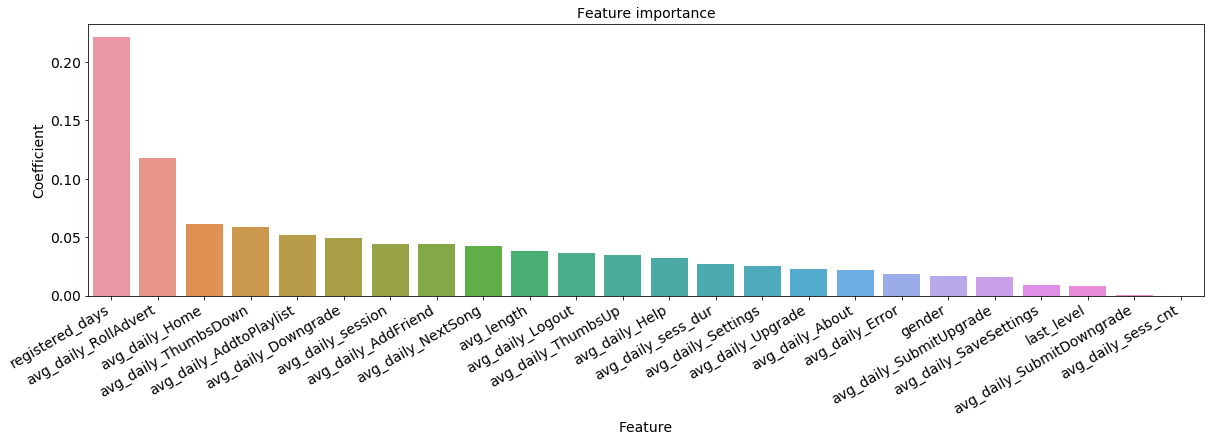

In [107]:
# Visualize the feature importance
best_model = models["rf"]
best_pred = best_model.transform(train)
feature_cofs_df = get_feature_cofs(best_model, best_pred, feature_df=feature_df, clf="rf")


    auc: 0.5630630630630631
    f1_score: 0.8715430546825896
    accuracy: 0.8604651162790697
    precision: 0.8456621388620211
    recall: 0.8488372093023255
    
Best parameters : numTrees:75, maxDepth:20


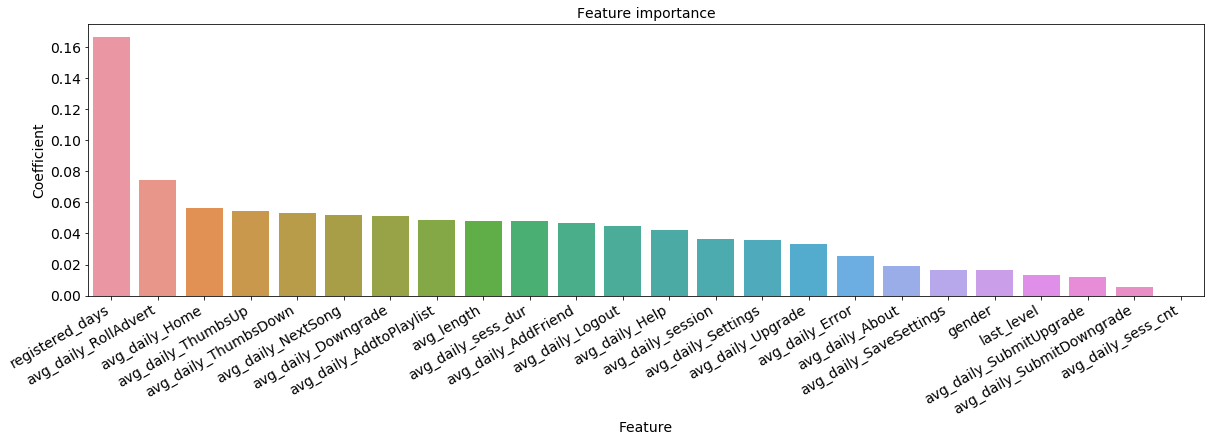

In [12]:
# Fine tuning the result
best_model = tune_rf(train, test)
best_pred = best_model.transform(train)
feature_cofs_df = get_feature_cofs(best_model, best_pred, feature_df=feature_df, clf="rf")

With adjusting parameter, we achieved even better `f1 score` from `0.8238` to `0.8715`. Now we can store the model for further usage.

In [15]:
model_file_name = "random_forest_tree75_depth20"
best_model.save(model_file_name)

#### Model can be accessed from HUE UI as below.

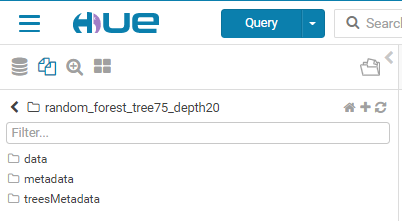